In [54]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt, pingouin as pin

from math import sqrt
import pylab
import ast
import networkx as nx
pd.set_option('precision', 2)
pd.options.display.float_format = '{:20.2f}'.format
from matplotlib.colors import LinearSegmentedColormap

In [6]:
import cityImage as ci
import ABManalysis as af

## 1. Loading Data
### Coordinate System of the case study area for cartographic visualisations

In [7]:
# initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [8]:
input_path = 'Input/empiricalABM/'+city_name
output_path = 'Outputs/empiricalABM/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')

nodes.index, edges.index = nodes.nodeID, edges.edgeID
nodes.index.name, edges.index.name = None, None

## 1.1 Loading  the simulation's volumes

In [10]:
summary_clusters = pd.read_csv(output_path+'_clusters.csv', index_col = 0)
clusters = ['group0', 'group1', 'group2', 'group3', 'group4', 'group5']
columns = ['edgeID'] + summary_clusters.index.to_list() + ['hetero']
runs = 20
df_list = []

for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')
    df_tmp['hetero'] = df_tmp[clusters].sum(axis=1)
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)
    
df_list = []
configurations = ['nullGroup', 'population', 'hetero']
for configuration in configurations: 
    df_list.append(df[[col for col in df if col.startswith(configuration)]+['edgeID']])
    
# aggregate runs values
edges = af.aggregate_runs(df_list, configurations, edges, ddof = 0)

In [17]:
df_list = []

for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')
    df_tmp['hetero'] = df_tmp[clusters].sum(axis=1)
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)

In [24]:
//

edgeID_0         9
group1_0         3
group2_0         3
group3_0         5
group0_0         1
group4_0         0
group5_0         2
population_0    18
nullGroup_0     21
hetero_0        14
Name: 0, dtype: int64

In [46]:
df

,edgeID_0,group1_0,group2_0,group3_0,group0_0,group4_0,group5_0,population_0,nullGroup_0,hetero_0
0,9,3,3,5,1,0,2,18,21,14
1,24,2,1,1,1,0,1,11,10,6
2,32,9,5,3,3,0,0,26,13,20
3,37,11,2,4,1,2,1,21,9,21
4,38,8,0,2,4,2,4,26,21,20
...,...,...,...,...,...,...,...,...,...,...
3899,30338,5,5,3,3,1,0,8,4,17
3900,14590,5,6,3,1,2,1,12,15,18
3901,15234,4,0,0,0,1,2,9,11,7
3902,30300,11,4,8,3,1,3,31,22,30


In [202]:
edges['hetero_pvalue'][edges['hetero_pvalue'] <0.001].loc[37]

0.0005855560302734375

In [139]:
labels = ['null', 'homogeneous', 'heterogeneous']
edges_list = list(edges['edgeID'])

df_edges = []
for edge in edges_list:
    df_tmp = pd.DataFrame(columns=['value','configuration'])
    
    for n, df in enumerate(df_list):
        df = df.copy()
        df.index = df['edgeID_'+str(n)]
        row = df.loc[edge]
        values = [row['nullGroup_'+str(n)], row['population_'+str(n)], row['hetero_'+str(n)]]
        for nn, value in enumerate(values):  
            df_tmp.loc[-1] = [value, labels[nn]]
            df_tmp.index = df_tmp.index + 1
            
    df_tmp['value'] = df_tmp['value'].astype(int)
    df_edges.append(df_tmp)

In [343]:
edges['hetero_pvalue'] = 0.000
edges['homo_pvalue'] = 0.000
edges['homo_pvalue_cl'] = "No significant diff."
edges['hetero_pvalue_cl'] = "No significant diff."

for n, df_edge in enumerate(df_edges):
    x = df_edge[df_edge['configuration'] == 'null']['value'].to_list()
    y = df_edge[df_edge['configuration'] == 'heterogeneous']['value'].to_list()
    z = df_edge[df_edge['configuration'] == 'homogeneous']['value'].to_list()

    # null vs heterogeneous
    if x != y:
        hetero = pin.wilcoxon(x = x, y = y, alternative='two-sided')
        hetero_pvalue = hetero.iloc[0]['p-val']
    else:
        hetero_pvalue = 1.0
    
    # null vs homogeneous
    if x != z:
        homo = pin.wilcoxon(x = x, y = z, alternative='two-sided')
        homo_pvalue = homo.iloc[0]['p-val']
    else:
        homo_pvalue = 1.0
    
    edge = edges_list[n]
    edges.at[edge, 'hetero_pvalue'] = hetero_pvalue
    edges.at[edge, 'homo_pvalue'] = homo_pvalue
    
    if edges.loc[edge]['hetero_pvalue'] <= 0.05:
        if edges.loc[edge]['hetero'] > edges.loc[edge]['nullGroup']:
            color_hetero = "Significant diff. (+)"
        else:
            color_hetero = "Significant diff. (-)"
        edges.at[edge, 'hetero_pvalue_cl'] = color_hetero
            
    if edges.loc[edge]['homo_pvalue'] <= 0.05:
        if edges.loc[edge]['population'] > edges.loc[edge]['nullGroup']:
            color_homo = "Significant diff. (+)"      
        else:
            color_homo = "Significant diff. (-)"
        edges.at[edge, 'homo_pvalue_cl'] = color_homo

In [ ]:


scenarios = ['RD scenario', 'AC scenario', 'RL scenario', 'AL scenario']
labels = ['lL', 'gL']
titles = ['Local Landmarkness', 'Global Landmarkness']

routes_stats = af.generate_routes_stats(routes_gdfs, scenarios, labels, titles)
trajectory_stats = af.generate_routes_stats([tracks], ['Trajectories'], labels, titles)
routes_stats = routes_stats.append(trajectory_stats)
routes_stats = routes_stats.reset_index(drop = True)

In [15]:
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')

,group1_0,group2_0,group3_0,group0_0,group4_0,group5_0,population_0,nullGroup_0,hetero_0,group1_1,...,group1_19,group2_19,group3_19,group0_19,group4_19,group5_19,population_19,nullGroup_19,hetero_19,edgeID
0,3,3,5,1,0,2,18,21,14,7,...,4,3,5,3,0,2,13,20,17,9
1,2,1,1,1,0,1,11,10,6,4,...,1,1,2,0,0,0,7,14,4,24
2,9,5,3,3,0,0,26,13,20,11,...,6,7,4,2,0,3,16,17,22,32
3,11,2,4,1,2,1,21,9,21,7,...,6,7,2,1,0,4,20,19,20,37
4,8,0,2,4,2,4,26,21,20,5,...,5,6,4,3,1,1,23,25,20,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,5,5,3,3,1,0,8,4,17,5,...,2,4,3,1,0,0,10,6,10,30338
3900,5,6,3,1,2,1,12,15,18,3,...,2,3,5,0,1,1,12,13,12,14590
3901,4,0,0,0,1,2,9,11,7,3,...,1,1,4,4,0,1,16,19,11,15234
3902,11,4,8,3,1,3,31,22,30,6,...,7,5,5,3,2,10,33,27,32,30300


### Volumes per cluster - Hetergeneous configuration

In [10]:
edges_clusters = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
summary_clusters = pd.read_csv(output_path+'_clusters.csv', index_col = 0)

columns = ['edgeID'] + clusters
runs = 20
df_list = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)
    
df_list = []
for cluster in clusters: 
    df_list.append(df[[col for col in df if col.startswith(cluster)]+['edgeID']])
    
# aggregate runs values
edges_clusters = af.aggregate_runs(df_list, clusters, edges_clusters, ddof = 0)

## 1.2 Loading the simulation's resulting routes

In [543]:
input_path_routes = 'Input/empiricalABM/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_empirical_DMA_'+str(run)+'.shp')
    run_gdf.set_crs(crs)
    
    for n, configuration in enumerate(configurations):
        if configuration == 'hetero':
            configuration_gdf = run_gdf[run_gdf.group.isin(clusters)].copy()
        else:
            configuration_gdf = run_gdf[run_gdf.group == configuration].copy()
        if run == 0:
            routes_gdf = configuration_gdf.copy()
            routes_gdfs.append(configuration_gdf)
            continue
        
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(configuration_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdf = routes_gdf.where(pd.notnull(routes_gdf), None)
        routes_gdf.replace({"None":None}, inplace = True)
        routes_gdfs[n] = routes_gdf

In [544]:
# preparing the routes gdf
for n, configuration in enumerate(configurations): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf
    
# for n, configuration in enumerate(configurations):     
#     routes_gdf = routes_gdfs[n].copy()
#     routes_gdf[['ped', 'maj', 'bar', 'districts']] = routes_gdf.apply(lambda row: af.regionBased_variables(row['edgeIDs'],
#                                            row['geometry'], nodes,  edges), axis = 1, result_type='expand')
#     routes_gdfs[n] = routes_gdf

## 1 Computing statistics of each route
### 1.1 Deviation from the road-distance shortest path

In [545]:
graph = ci.graph_fromGDF(nodes, edges, nodeID = "nodeID")
distances = {}
routes_gdf = routes_gdfs[0].copy()
for routes_gdf in routes_gdfs:
    for row in routes_gdf.itertuples():
        source = routes_gdf.loc[row[0]]['O']
        target = routes_gdf.loc[row[0]]['D']
        if str(source)+"-"+str(target) in distances:
            continue
        distance = nx.shortest_path_length(graph, source=source, target=target, weight='length', method='dijkstra')
        distances[str(source)+"-"+str(target)] = distance

## 2 Getting the statistics
### 2.1 Deviation from the road-distance shortest path

In [546]:
variables = ['barrier', 'routeMark', 'regions', 'distant']

for cluster in clusters:
    print(cluster)
    tmp = routes_gdfs[2][routes_gdfs[2].group == cluster].copy()
    l = len(tmp)
    for variable in variables:
        print(variable, str(round(len(tmp[tmp[variable] == 1])/l*100,2)) +"%")
    
    tmp["using"] = tmp.barrier +tmp.routeMark + tmp.regions + tmp.distant
    print("using elements", str(round(len(tmp[tmp["using"] > 0])/l*100,2))+"%")
    print("severing", round(tmp.severing.mean(),3))
    print("natural",  round(tmp.natural.mean(),3))
    print()
    
for n, configuration in enumerate(configurations):
    print(configuration)
    for variable in variables:
        l = len(routes_gdfs[n])
        print(variable, str(round(len(routes_gdfs[n][(routes_gdfs[n][variable] == 1)])/l*100,2))+"%")
    
    routes_gdfs[n]["using"] = routes_gdfs[n].barrier +routes_gdfs[n].routeMark + routes_gdfs[n].regions + routes_gdfs[n].distant
    print("using elements", str(round(len(routes_gdfs[n][(routes_gdfs[n]["using"] > 0)])/l*100,2))+"%")
    print("severing", round(routes_gdfs[n].severing.mean(),3))
    print("natural",  round(routes_gdfs[n].natural.mean(),3))
    print()

group0
barrier 21.32%
routeMark 32.03%
regions 20.82%
distant 16.7%
using elements 67.31%
severing 1.517
natural 0.54

group1
barrier 28.4%
routeMark 15.26%
regions 20.04%
distant 34.08%
using elements 66.45%
severing 1.52
natural 0.496

group2
barrier 20.91%
routeMark 12.74%
regions 14.11%
distant 34.37%
using elements 57.11%
severing 1.46
natural 0.496

group3
barrier 13.16%
routeMark 22.14%
regions 25.61%
distant 29.49%
using elements 61.66%
severing 1.642
natural 0.5

group4
barrier 7.3%
routeMark 37.7%
regions 23.17%
distant 12.06%
using elements 60.08%
severing 1.5
natural 0.565

group5
barrier 16.92%
routeMark 29.87%
regions 11.7%
distant 22.99%
using elements 60.22%
severing 1.557
natural 0.524

nullGroup
barrier 18.17%
routeMark 18.6%
regions 23.55%
distant 27.14%
using elements 49.53%
severing 1.503
natural 0.501

population
barrier 20.49%
routeMark 20.75%
regions 19.36%
distant 28.87%
using elements 62.57%
severing 1.537
natural 0.509

hetero
barrier 20.03%
routeMark 21.33%


In [547]:
for n, configuration in enumerate(configurations):

    routes_gdf = routes_gdfs[n].copy()
    if configuration == 'hetero':
        for cluster in list(clusters):
            group_gdf = routes_gdf[routes_gdf.group == cluster].copy()
            print("   in ", cluster)
            print("median routes' lenght:", round(group_gdf.geometry.length.median(),3))
            print("mean routes' lenght:", round(group_gdf.geometry.length.mean(),3))
            group_gdf['sp_dist'] = group_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
            group_gdf['sp_dev'] = group_gdf.geometry.length/group_gdf['sp_dist']
            print("median routes' deviation from SP", round(group_gdf['sp_dev'].median(),3))
    print()
    print(configuration)
    print("median routes' lenght:", round(routes_gdf.geometry.length.median(),3))
    print("mean routes' lenght:", round(routes_gdf.geometry.length.mean(),3))
    routes_gdf['sp_dist'] = routes_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    routes_gdf['sp_dev'] = routes_gdf.geometry.length/routes_gdf['sp_dist']
    print("median routes' deviation from SP", round(routes_gdf['sp_dev'].median(),3))
    print()
    routes_gdfs[n] = routes_gdf


nullGroup
median routes' lenght: 2477.92
mean routes' lenght: 2658.513
median routes' deviation from SP 1.132


population
median routes' lenght: 2523.551
mean routes' lenght: 2700.419
median routes' deviation from SP 1.182

   in  group0
median routes' lenght: 2543.53
mean routes' lenght: 2637.659
median routes' deviation from SP 1.204
   in  group1
median routes' lenght: 2542.783
mean routes' lenght: 2718.702
median routes' deviation from SP 1.194
   in  group2
median routes' lenght: 2612.126
mean routes' lenght: 2777.266
median routes' deviation from SP 1.164
   in  group3
median routes' lenght: 2464.947
mean routes' lenght: 2626.425
median routes' deviation from SP 1.156
   in  group4
median routes' lenght: 2453.632
mean routes' lenght: 2534.721
median routes' deviation from SP 1.154
   in  group5
median routes' lenght: 2505.575
mean routes' lenght: 2665.691
median routes' deviation from SP 1.201

hetero
median routes' lenght: 2527.17
mean routes' lenght: 2682.444
median routes' d

### *Saving and Loading*

In [11]:
# export routes
for n, model in enumerate(route_choice_models):
    routes_gdfs[n]['ds_str'] = routes_gdfs[n]['districts'].astype(str)
    routes_gdfs[n].drop(['districts', 'edgeIDs'], axis = 1, errors = 'ignore').to_file(
        output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')

In [6]:
## reload routes
routes_gdfs = []
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
for n, model in enumerate(route_choice_models):
    routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['districts'] = [ast.literal_eval(i) for i in routes_gdf['ds_str']]
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

## 2. Volumes

### Saving volumes

In [576]:
edges.to_file(output_path+'_pedSim_empirical.shp', use_unicode=True, driver='ESRI Shapefile')

## Visualisation

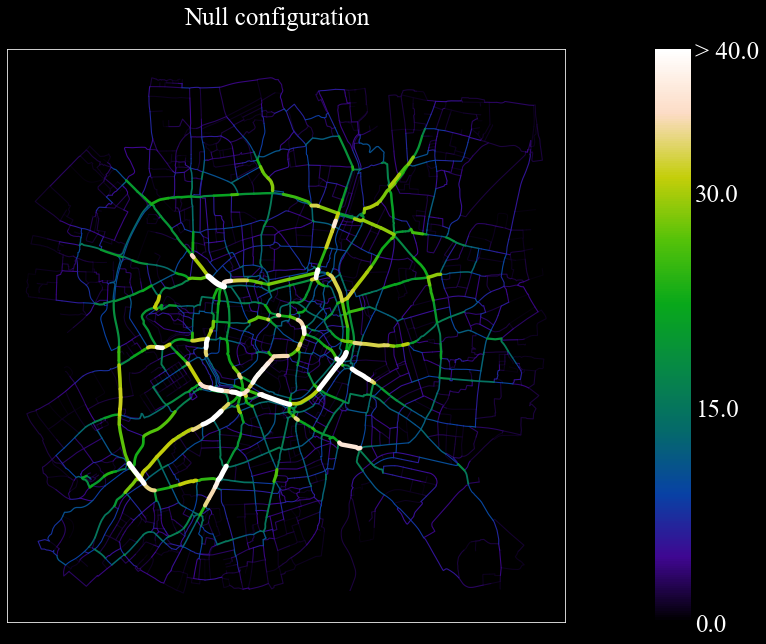

In [572]:
subtitles = ['Null configuration']
norm = mpl.colors.Normalize(vmin = 0, vmax = 40)
fig = ci.plot_gdf(edges, column = configurations[0], cmap = ci.kindlmann(), norm = norm, title = subtitles[0], fig_size = 10,
                       legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.12, axes_frame = True)

In [555]:
fig.savefig("Outputs/Figures/empiricalABM/f6.pdf", bbox_inches='tight')

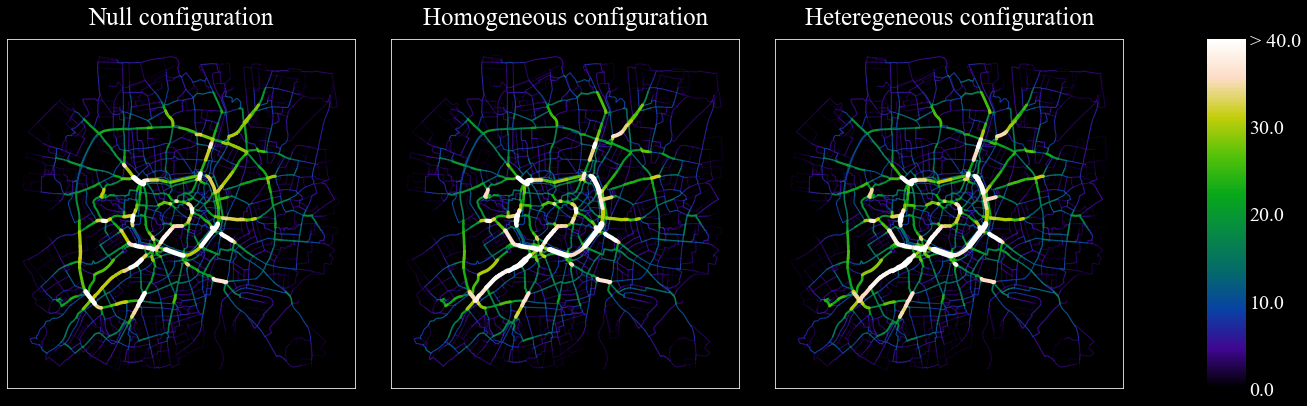

In [553]:
subtitles = [ 'Null configuration', 'Homogeneous configuration', 'Heteregeneous configuration',]
cols = ['null', 'homo', 'hetero']
norm = mpl.colors.Normalize(vmin = 0, vmax = 40)

fig = ci.plot_gdf_grid(edges, ncols = 3, fig_size = 20, columns = configurations, cmap = ci.kindlmann(), titles = subtitles, 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = True, lw_factor = 0.11, 
                    axes_frame = True,  black_background = True)

In [372]:
edges

,edgeID,key,length,highway,oneway,lanes,name,bridge,tunnel,pedestrian,...,population_std,population_mean,hetero_std,hetero_mean,hetero_pvalue,homo_pvalue,homo_pvalue_cl,hetero_pvalue_cl,homo_diff,hetero_diff
9,9,0,195.12,secondary,0,3,Weseler Straße,0,None,0,...,4.90,15.35,3.89,15.30,0.02,0.04,Significant diff. (-),Significant diff. (-),3.50,4.50
24,24,0,57.19,secondary,0,3,Moltkestraße,0,None,0,...,2.72,8.25,3.89,8.85,0.00,0.00,Significant diff. (-),Significant diff. (-),5.00,4.00
32,32,0,54.94,secondary,0,3,Schorlemerstraße,0,None,0,...,2.96,17.60,5.99,17.35,0.03,0.00,Significant diff. (+),Significant diff. (+),4.50,4.00
37,37,0,67.51,residential,0,2,Am Kanonengraben,0,None,0,...,3.52,19.20,5.32,18.90,0.00,0.00,Significant diff. (+),Significant diff. (+),7.00,8.00
38,38,0,75.83,secondary,0,2,Hafenstraße,0,None,0,...,5.42,17.85,4.14,17.95,0.00,0.00,Significant diff. (-),Significant diff. (-),6.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30338,30338,0,13.22,path,0,None,None,0,None,1,...,2.56,8.95,3.57,10.35,0.00,0.00,Significant diff. (+),Significant diff. (+),2.50,4.00
14590,14590,0,214.64,service,0,None,None,0,None,1,...,1.94,9.55,3.07,9.85,0.01,0.01,Significant diff. (-),Significant diff. (-),3.00,3.50
15234,15234,0,80.22,service,0,None,None,0,None,0,...,2.80,10.45,3.09,10.40,0.02,0.01,Significant diff. (-),Significant diff. (-),2.50,2.50
30300,30300,0,374.80,footway,0,None,Promenade,0,yes,0,...,5.65,30.50,4.81,29.95,0.00,0.00,Significant diff. (+),Significant diff. (+),8.50,8.00


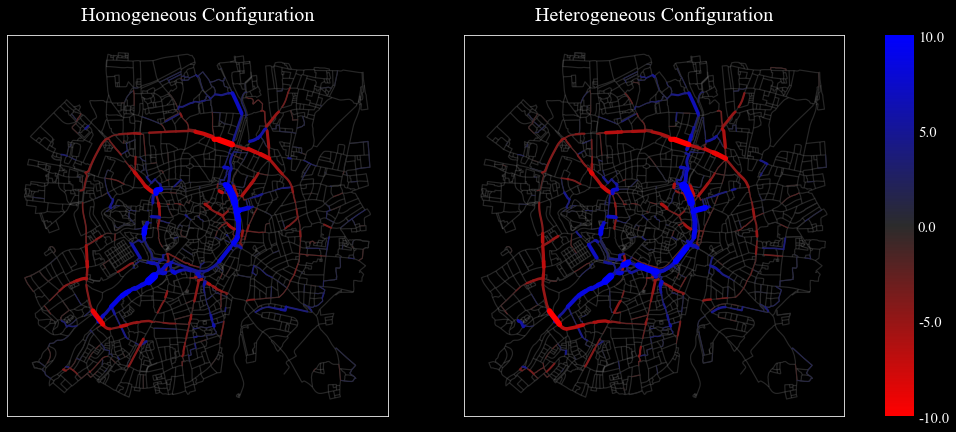

In [390]:
black_l = ci.lighten_color('black', 0.83)
subtitles = ['Homogeneous Configuration', 'Heterogeneous Configuration']
# edges['homo_diff'] = edges['population'] - edges['nullGroup']
# edges['hetero_diff'] = edges['hetero'] - edges['nullGroup']
# cols = ['homo_diff', 'hetero_diff']
norm = mpl.colors.Normalize(vmin = -10, vmax = 10)
cmap = LinearSegmentedColormap.from_list('BkR',['red', black_l,'blue',])

sign_homo = edges[edges.hetero_pvalue <= 0.05].copy()
sign_homo['diff'] = sign_homo['population'] - sign_homo['nullGroup']
sign_hetero = edges[edges.homo_pvalue <= 0.05].copy() 
sign_hetero['diff'] = sign_hetero['hetero'] - sign_hetero['nullGroup']

gdfs = [sign_homo, sign_hetero]
fig = plot_gdfs(gdfs, column = 'diff', cmap = cmap, titles = subtitles, norm = norm,
                       legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = False, lw_factor = 0.55, lw_column = 'diff',
                       axes_frame = True, black_background = True, gdf_base_map = edges, base_map_color = 'grey', 
                    base_map_alpha = 0.3, base_map_lw = 1.2, base_map_zorder = 0)

In [384]:
def plot_gdfs(list_gdfs = [], column = None, ncols = 2, main_title = None, titles = [], black_background = True, fig_size = 15,
              scheme = None, bins = None, classes = None, norm = None, cmap = None, color = None, alpha = None, 
                legend = False, cbar = False, cbar_ticks = 5, cbar_max_symbol = False, only_min_max = False, 
              axes_frame = False, ms = None, ms_factor = None, lw = None, lw_factor = None, lw_column = None,
                 gdf_base_map = pd.DataFrame({"a" : []}), base_map_color = None, base_map_alpha = 0.4,
                base_map_lw = 1.1, base_map_ms = 2.0, base_map_zorder = 0): 
                     
    """
    It plots the geometries of a list of GeoDataFrame, containing the same type of geometry. Coloring is based on a provided column (that needs to be a column in each passed GeoDataFrame), using a given scheme.
    If only "column" is provided, a categorical map is depicted.
    If no column is provided, a plain map is shown.
    
    Parameters
    ----------
    list_gdfs: list of GeoDataFrames
        GeoDataFrames to be plotted
    column: string
        Column on which the plot is based
    main_title: string 
        main title of the plot
    titles: list of string
        list of titles to be assigned to each quadrant (axes) of the grid
    black_background: boolean 
        black background or white
    fig_size: float
        size figure extent
    scheme: string
        classification method, choose amongst: https://pysal.org/mapclassify/api.html
    bins: list
        bins defined by the user
    classes: int
        number of classes for categorising the data when scheme is not "None"
    norm: array
        a class that specifies a desired data normalisation into a [min, max] interval
    cmap: string, matplotlib.colors.LinearSegmentedColormap
        see matplotlib colormaps for a list of possible values or pass a colormap
    color: string
        categorical color applied to all geometries when not using a column to color them
    alpha: float
        alpha value of the plotted layer
    legend: boolean
        if True, show legend, otherwise don't
    cbar: boolean
        if True, show colorbar, otherwise don't; when True it doesn't show legend
    cbar_ticks: int
        number of ticks along the colorbar
    cbar_max_symbol: boolean
        if True, it shows the ">" next to the highest tick's label in the colorbar (useful when normalising)
    only_min_max: boolean
        if True, it only shows the ">" and "<" as labels of the lowest and highest ticks' the colorbar
    axes_frame: boolean
        if True, it shows the axes' frame
    ms: float
        point size value, when plotting a Point GeoDataFrame
    ms_factor: float 
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the ms_factor to rescale the marker size accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a Point GeoDataFrame
    lw: float
        line width, when plotting a LineString GeoDataFrame
    lw_factor: float
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the lw_factor to rescale the line width accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a LineString GeoDataFrame   
        
    
    Returns
    -------
    fig: matplotlib.figure.Figure object
        the resulting figure
    """              
                     
    if ncols == 2:
        nrows, ncols = int(len(list_gdfs)/2), 2
        if (len(list_gdfs)%2 != 0): 
            nrows = nrows+1
    else:
        nrows, ncols = int(len(list_gdfs)/3), 3
        if (len(list_gdfs)%3 != 0): 
            nrows = nrows+1

    multiPlot = MultiPlot(fig_size = fig_size, nrows = nrows, ncols = ncols, black_background = black_background, 
                          title = main_title)
    
    fig, grid = multiPlot.fig, multiPlot.grid   
    legend_fig = False
    
    if nrows > 1: 
        grid = [item for sublist in grid for item in sublist]
    for n, ax in enumerate(grid):
                
        ax.set_aspect("equal")
        if axes_frame: 
            _set_axes_frame(ax, black_background, multiPlot.text_color)
        else: 
            ax.set_axis_off()      

        if n > len(list_gdfs)-1: 
            continue # when odd nr of gdfs    
        
        gdf = list_gdfs[n]
        if len(titles) > 0:
            ax.set_title(titles[n], loc='center', fontfamily = 'Times New Roman', fontsize = multiPlot.font_size, color = multiPlot.text_color,  pad = 15)
            
        if (n == ncols*nrows/2) & legend & ((scheme == 'User_Defined') | (scheme == 'Lynch_Breaks')):
            legend_ax = True
            legend_fig = True
        elif legend & ((scheme != 'User_Defined') & (scheme != 'Lynch_Breaks')):
            legend_ax = True
        else: 
            legend_ax = False
            legend_fig = False
            
        zorder = 0
        # base map (e.g. street network)
        if (not gdf_base_map.empty):
            if gdf_base_map.iloc[0].geometry.geom_type == 'LineString':
                gdf_base_map.plot(ax = ax, color = base_map_color, linewidth = base_map_lw, alpha = base_map_alpha, zorder = base_map_zorder)
            if gdf_base_map.iloc[0].geometry.geom_type == 'Point':
                gdf_base_map.plot(ax = ax, color = base_map_color, markersize = base_map_ms, alpha = base_map_alpha, zorder = base_map_zorder)
            if gdf_base_map.iloc[0].geometry.geom_type == 'Polygon':
                gdf_base_map.plot(ax = ax, color = base_map_color, alpha = base_map_alpha, zorder = base_map_zorder)
            if base_map_zorder == 0:
                zorder = 1
        
        _single_plot(ax, gdf, column = column, scheme = scheme, bins = bins, classes = classes, norm = norm, cmap = cmap, 
                     color = color, alpha = alpha, legend = legend_ax, 
                    ms = ms, ms_factor = ms_factor, lw = lw, lw_factor = lw_factor, lw_column = lw_column)
                    
        if legend_fig:
            _generate_legend_fig(ax, nrows, multiPlot.text_color, (multiPlot.font_size-5), black_background)
        elif legend_ax:
            _generate_legend_ax(ax, (multiPlot.font_size-15), black_background)
    
    if (cbar) & (not legend):
        if norm is None:
            min_value = min([gdf[column].min() for gdf in list_gdfs])
            max_value = max([gdf[column].max() for gdf in list_gdfs])
            norm = plt.Normalize(vmin = min_value, vmax = max_value)
        generate_grid_colorbar(cmap, fig, grid, nrows, ncols, multiPlot.text_color,(multiPlot.font_size-5), norm = norm, ticks = cbar_ticks, 
                              symbol = cbar_max_symbol, only_min_max = only_min_max )
            
    return fig

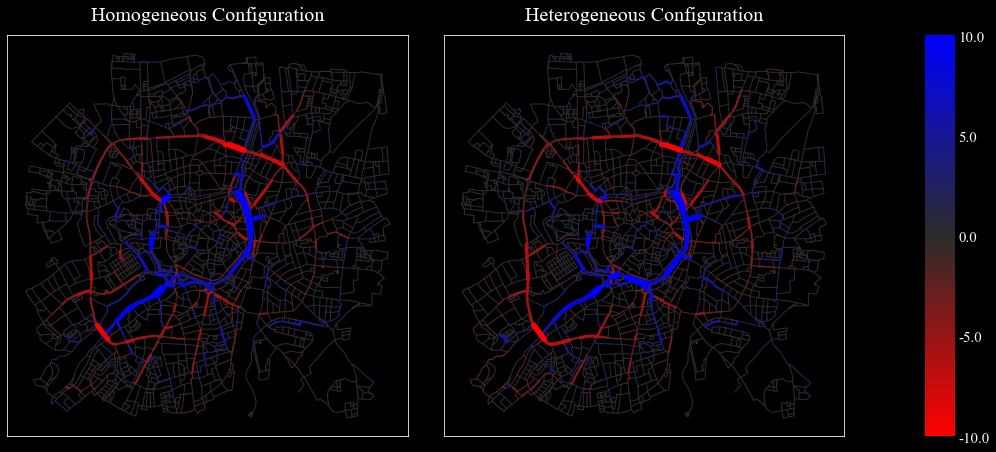

In [573]:
black_l = ci.lighten_color('black', 0.83)
subtitles = ['Homogeneous Configuration', 'Heterogeneous Configuration']
edges['homo_diff'] = edges['population'] - edges['nullGroup']
edges['hetero_diff'] = edges['hetero'] - edges['nullGroup']
cols = ['homo_diff', 'hetero_diff']
norm = mpl.colors.Normalize(vmin = -10, vmax = 10)
cmap = LinearSegmentedColormap.from_list('BkR',['red', black_l,'blue',])

sign_homo = edges[edges.hetero_pvalue <= 0.05].copy()
sign_hetero = edges[edges.homo_pvalue <= 0.05].copy() 

fig = ci.plot_gdfs(edges, columns = cols, cmap = cmap, titles = subtitles, norm = norm,
                       legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = False, lw_factor = 0.55,
                       axes_frame = True, black_background = True)

In [175]:
edges['homo_pvalue_cl'].unique()

array([-2., -3.,  3., -1.,  1.,  0.,  2.])

In [193]:
edges['homo_pvalue'].unique()

array([-2., -3.,  3., -1.,  1.,  0.,  2.])

In [256]:
def _generate_legend_ax(ax, font_size, black_background):

    leg = ax.get_legend()  
    if black_background:
        text_color = 'black'
    else: 
        text_color = 'white'
    
    plt.setp(leg.texts, family='Times New Roman', fontsize = font_size, color = text_color, va = 'center')
    leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
    leg.get_frame().set_linewidth(0.0) # remove legend border
    leg.set_zorder(102)
    
#     for handle in leg.legendHandles:
#         handle._legmarker.set_markersize(12)
        
    if not black_background:
        leg.get_frame().set_facecolor('black')
        leg.get_frame().set_alpha(0.90)  
    else:
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_alpha(0.90)  

0
1
fig


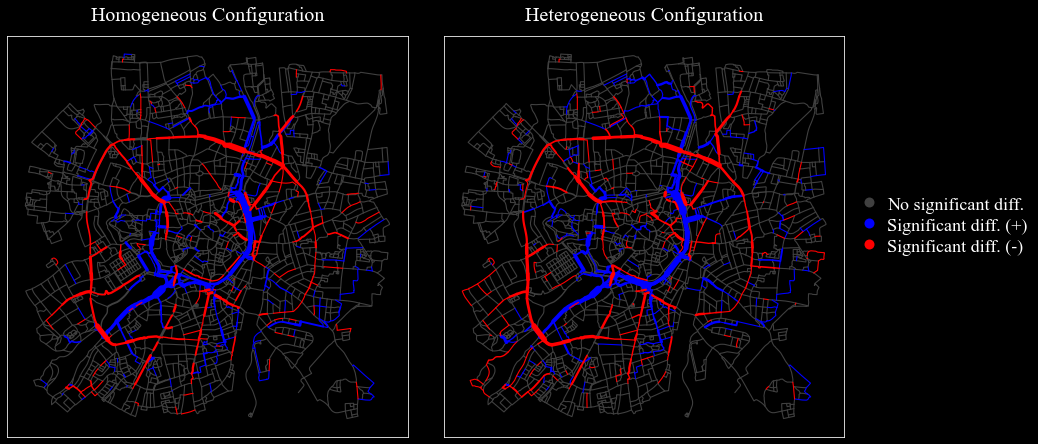

In [407]:
black_l = ci.lighten_color('black', 0.75)
black_c = ci.lighten_color('grey', 1.00)
red_l = ci.lighten_color('red', 0.40)
blue_l = ci.lighten_color('yellow', 0.40)
# black_l = ci.lighten_color('black', 0.83)

subtitles = ['Homogeneous Configuration', 'Heterogeneous Configuration']
edges['homo_diff'] = abs(edges['population'] - edges['nullGroup'])
edges['hetero_diff'] = abs(edges['hetero'] - edges['nullGroup'])
lw_columns = ['homo_diff', 'hetero_diff']
cols = ['homo_pvalue_cl', 'hetero_pvalue_cl']
# norm = mpl.colors.Normalize(vmin = -10, vmax = 10)
cmap = LinearSegmentedColormap.from_list('BkR',['red', red_l, black_l,black_c, black_l, blue_l, 'blue',])

list_colors = [black_l, 'blue','red',]
cmap = LinearSegmentedColormap.from_list('custom_cmap', list_colors)
# # lw_factor = 0.55
# bins = [+3, +2, +1, 0, +1, +2, +3]
fig = plot_gdf_grid(edges, columns = cols, classes = 5, cmap = cmap, titles = subtitles, legend = True, 
                    axes_frame = True, scheme = None,
                       lw_columns = lw_columns, lw_factor = 0.55, black_background = True)

In [408]:
fig.savefig("Outputs/Figures/empiricalABM/f7a.pdf", bbox_inches='tight')

In [342]:
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

array([' Significant diff. (+)', 'No significant diff.',
       'Significant diff. (-)'], dtype=object)

In [369]:
def _generate_legend_fig(ax, nrows, ncols, text_color, font_size, black_background):
    """ 
    It generates the legend for an entire figure.
    
    Parameters
    ----------
    ax: matplotlib.axes object
        the Axes on which plotting
    nrows: int
        number of rows in the figure
    text_color: string
        the text color
    font_size: int
        the legend's labels text size
    """
    
    leg = ax.get_legend() 
    plt.setp(leg.texts, family='Times New Roman', fontsize = 18, color = text_color, va = 'center')
    
    if ncols == 2:
        if nrows%2 == 0: 
            leg.set_bbox_to_anchor((2.15, 1.00, 0.33, 0.33))    
        else: 
            leg.set_bbox_to_anchor((1.15, 0.3, 0.33, 0.33))
    
    elif ncols == 3:
        if nrows%2 == 0: 
            leg.set_bbox_to_anchor((2.25, 1.15, 0.33, 0.33))    
        else:     
            leg.set_bbox_to_anchor((1.25, 0.65, 0.33, 0.33))
        
    leg.get_frame().set_linewidth(0.0) # remove legend border
    leg.set_zorder(102)
    leg.get_frame().set_facecolor('none')
    
#     for handle in leg.legendHandles:
#         handle._legmarker.set_markersize(15)


def _generate_legend_ax(ax, font_size, black_background):
    """ 
    It generate the legend for a figure.
    
    Parameters
    ----------
    ax: matplotlib.axes object
        the Axes on which plotting
    text_color: string
        the text color
    font_size: int
        the legend's labels text size
    """
    leg = ax.get_legend()  
    if black_background:
        text_color = 'black'
    else: 
        text_color = 'white'
    
    plt.setp(leg.texts, family='Times New Roman', fontsize = font_size, color = text_color, va = 'center')
    leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
    leg.get_frame().set_linewidth(0.0) # remove legend border
    leg.set_zorder(102)
    
#     for handle in leg.legendHandles:
#         handle._legmarker.set_markersize(12)
        
    if not black_background:
        leg.get_frame().set_facecolor('black')
        leg.get_frame().set_alpha(0.90)  
    else:
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_alpha(0.90)  



def plot_gdf_grid(gdf = None, columns = [], ncols = 2, titles = [], black_background = True, fig_size = 15, scheme = 
                  None, bins = None, classes = None, norm = None, cmap = None, color = None, alpha = None, 
                legend = False, cbar = False, cbar_ticks = 5, cbar_max_symbol = False, only_min_max = False, 
                  axes_frame = False, ms = None, ms_factor = None, lw = None, lw_factor = None, lw_columns = []): 
    """
    It plots the geometries of a GeoDataFrame, coloring on the bases of the values contained in the provided columns, using a given scheme.
    If only "column" is provided, a categorical map is depicted.
    If no column is provided, a plain map is shown.
    
    Parameters
    ----------
    gdf: GeoDataFrame
        GeoDataFrame to be plotted 
    column: string
        Column on which the plot is based
    title: string 
        title of the plot
    black_background: boolean 
        black background or white
    fig_size: float
        size figure extent
    scheme: string
        classification method, choose amongst: https://pysal.org/mapclassify/api.html
    bins: list
        bins defined by the user
    classes: int
        number of classes for categorising the data when scheme is not "None"
    norm: array
        a class that specifies a desired data normalisation into a [min, max] interval
    cmap: string, matplotlib.colors.LinearSegmentedColormap
        see matplotlib colormaps for a list of possible values or pass a colormap
    color: string
        categorical color applied to all geometries when not using a column to color them
    alpha: float
        alpha value of the plotted layer
    legend: boolean
        if True, show legend, otherwise don't
    cbar: boolean
        if True, show colorbar, otherwise don't; when True it doesn't show legend
    cbar_ticks: int
        number of ticks along the colorbar
    cbar_max_symbol: boolean
        if True, it shows the ">" next to the highest tick's label in the colorbar (useful when normalising)
    only_min_max: boolean
        if True, it only shows the ">" and "<" as labels of the lowest and highest ticks' the colorbar
    axes_frame: boolean
        if True, it shows the axes' frame
    ms: float
        point size value, when plotting a Point GeoDataFrame
    ms_factor: float 
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the ms_factor to rescale the marker size accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a Point GeoDataFrame
    lw: float
        line width, when plotting a LineString GeoDataFrame
    lw_factor: float
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the lw_factor to rescale the line width accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a LineString GeoDataFrame
    """   
    
    if ncols == 2:
        nrows, ncols = int(len(columns)/2), 2
        if (len(columns)%2 != 0): 
            nrows = nrows+1
    else:
        nrows, ncols = int(len(columns)/3), 3
        if (len(columns)%3 != 0): 
            nrows = nrows+1
    
    multiPlot = MultiPlotGrid(fig_size = fig_size, nrows = nrows, ncols = ncols, black_background = black_background)
    fig, grid = multiPlot.fig, multiPlot.grid   
    legend_fig = False
    
    for n, ax in enumerate(grid):
        
        ax.set_aspect("equal")
        if axes_frame: 
            _set_axes_frame(ax, black_background, multiPlot.text_color)
        else: 
            ax.set_axis_off()
        
        if n > len(columns)-1: 
            continue # when odd nr of columns
        
        column = columns[n]
        if len(titles) > 0:          
            ax.set_title(titles[n], loc='center', fontfamily = 'Times New Roman', fontsize = multiPlot.font_size, color = multiPlot.text_color,  pad = 15)
        
        if (n == ncols*nrows/2) & legend:
            legend_ax = True
            legend_fig = True
        elif legend & ((scheme != 'User_Defined') & (scheme != 'Lynch_Breaks') & (gdf[column].dtype != 'O')):
            legend_ax = True
        else:
            legend_ax = False
            legend_fig = False
        
        if len(lw_columns) == 0:
            lw_column = None
        else:
            lw_column = lw_columns[n]
        
        _single_plot(ax, gdf, column = column, scheme = scheme, bins = bins, classes = classes, norm = norm, cmap = cmap, 
                     color = color, alpha = alpha, legend = legend_ax,
                    ms = ms, ms_factor = ms_factor, lw = lw, lw_column = lw_column, lw_factor = lw_factor)
                 
        print(n)   
        if legend_fig:
            print('fig')
            _generate_legend_fig(ax, nrows, ncols, multiPlot.text_color, multiPlot.font_size-5, black_background)
        elif legend_ax:
            print('ax')
            _generate_legend_ax(ax, (multiPlot.font_size-5), black_background)
            
    if (cbar) & (not legend):
        if norm is None:
            min_value = min([gdf[column].min() for column in columns])
            max_value = max([gdf[column].max() for column in columns])
            norm = plt.Normalize(vmin = min_value, vmax = max_value)
        generate_grid_colorbar(cmap, fig, grid, nrows, ncols, multiPlot.text_color,multiPlot.font_size-5, norm = norm, ticks = cbar_ticks, 
                              symbol = cbar_max_symbol, only_min_max = only_min_max)

    return fig


def _single_plot(ax, gdf, column = None, scheme = None, bins = None, classes = None, norm = None, cmap = None, color = None, alpha = None, 
                legend = False, ms = None, ms_factor = None, lw = None, lw_column = None, lw_factor = None,  zorder = 0):
    """
    It plots the geometries of a GeoDataFrame, coloring on the bases of the values contained in column, using a given scheme, on the provided Axes.
    If only "column" is provided, a categorical map is depicted.
    If no column is provided, a plain map is shown.
    
    Parameters
    ----------
    ax: matplotlib.axes object
        the Axes on which plotting
    gdf: GeoDataFrame
        GeoDataFrame to be plotted 
    column: string
        Column on which the plot is based
    scheme: string
        classification method, choose amongst: https://pysal.org/mapclassify/api.html
    bins: list
        bins defined by the user
    classes: int
        classes for visualising when scheme is not "None"
    norm: array
        a class that specifies a desired data normalisation into a [min, max] interval
    cmap: string, matplotlib.colors.LinearSegmentedColormap
        see matplotlib colormaps for a list of possible values or pass a colormap
    color: string
        categorical color applied to all geometries when not using a column to color them
    alpha: float
        alpha value of the plotted layer
    legend: boolean
        if True, show legend, otherwise don't
    ms: float
        point size value, when plotting a Point GeoDataFrame
    ms_factor: float 
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the ms_factor to rescale the marker size accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a Point GeoDataFrame
    lw: float
        line width, when plotting a LineString GeoDataFrame
    lw_factor: float
        when provided, it rescales the column provided, if any, from 0 to 1 and it uses the lw_factor to rescale the line width accordingly 
        (e.g. rescaled variable's value [0-1] * factor), when plotting a LineString GeoDataFrame
    zorder: int   
        zorder of this layer; e.g. if 0, plots first, thus main GeoDataFrame on top; if 1, plots last, thus on top.
    """  
    
    gdf = gdf.copy()
    categorical = True
    if alpha is None:
        alpha = 1
    if (column is not None) & (gdf[column].dtype != 'O'):
        gdf = gdf.reindex(gdf[column].abs().sort_values(ascending = True).index)
    else:
        gdf = gdf.reindex(gdf[column].sort_values(ascending = True).index)
    
    # single-colour map
    if (column is None) & (scheme is None) & (color is None):
        color = 'red'
    
    # categorical map
    elif (column is not None) & (scheme is None) & (norm is None) & (cmap is None): 
        cmap = rand_cmap(len(gdf[column].unique()))         
    
    # Lynch's bins - only for variables from 0 to 1 
    elif scheme == "Lynch_Breaks":  
        scaling_columnDF(gdf, column)
        column = column+"_sc"
        bins = [0.125, 0.25, 0.5, 0.75, 1.00]
        scheme = 'User_Defined'
        categorical = False
    
    elif norm is not None:
        legend = False
        categorical = False
        scheme = None
    
    elif (scheme is not None) & (classes is None) & (bins is None):
        classes = 7   
    
    if (scheme is not None) & (cmap is None) :
        cmap = kindlmann()
    
    if (scheme is not None) | (norm is not None):
        categorical = False
        color = None
    
    if (column is not None) & (not categorical):
        if (gdf[column].dtype == 'O'):
            gdf[column] = gdf[column].astype(float)
    
    if bins is None: 
        c_k = {None}
        if classes is not None:
            c_k = {"k" : classes}
    else: 
        c_k = {'bins':bins, "k" : len(bins)}
        scheme = 'User_Defined'
    
    if gdf.iloc[0].geometry.geom_type == 'Point':
        if (ms_factor is not None): 
            # rescale
            scaling_columnDF(gdf, column)
            gdf['ms'] = np.where(gdf[column+'_sc'] >= 0.20, gdf[column+'_sc']*ms_factor, 0.40) # marker size
            ms = gdf['ms']
        elif ms is None:
            ms = 1.0
        else: 
            ms = ms

        gdf.plot(ax = ax, column = column, markersize = ms, categorical = categorical, color = color, scheme = scheme, cmap = cmap, norm = norm, alpha = alpha,
            legend = legend, classification_kwds = c_k, zorder = zorder) 
        
    if gdf.iloc[0].geometry.geom_type == 'LineString':
        if (lw is None) & (lw_factor is None): 
            lw = 1.00
        elif lw_factor is not None:
            lw = [(abs(value)*lw_factor) if (abs(value)*lw_factor) > 1.1 else 1.1 for value in gdf[lw_column]]
        
        gdf.plot(ax = ax, column = column, categorical = categorical, color = color, linewidth = lw, scheme = scheme, alpha = alpha, cmap = cmap, norm = norm,
            legend = legend, classification_kwds = c_k, capstyle = 'round', joinstyle = 'round', zorder = zorder) 
                
    if gdf.iloc[0].geometry.geom_type == 'Polygon': 
        gdf.plot(ax = ax, column = column, categorical = categorical, color = color, scheme = scheme, edgecolor = 'none', alpha = alpha, cmap = cmap,
            norm = norm, legend = legend, classification_kwds = c_k, zorder = zorder) 

In [371]:
fig.savefig("Outputs/Figures/empiricalABM/f7_a.pdf", bbox_inches='tight')

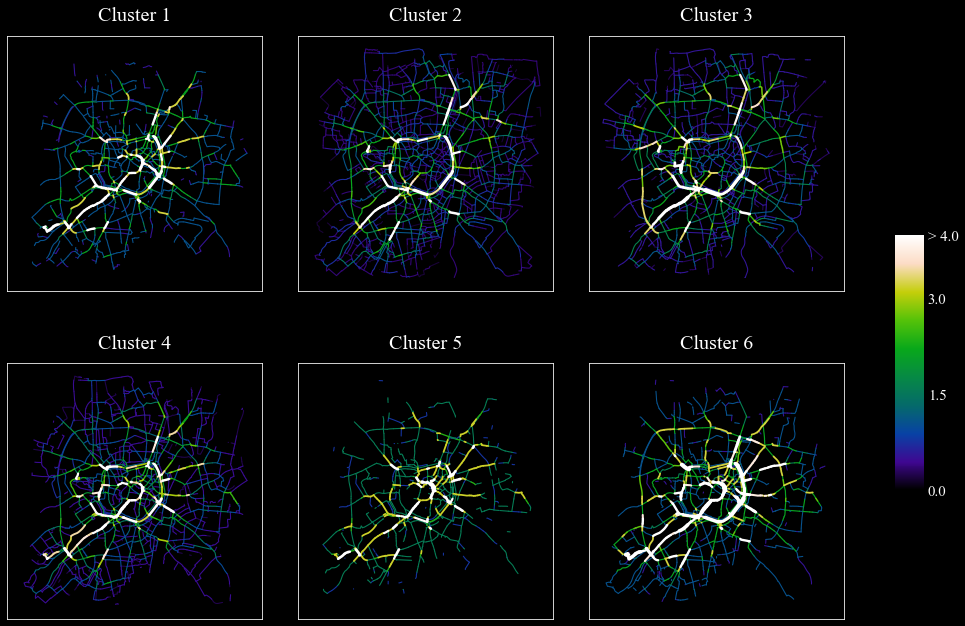

In [15]:
for cluster in clusters:
    edges_clusters[cluster+"_%"] = edges_clusters[cluster]/(301*summary_clusters.loc[cluster].portion*3)*100

# edges_clusters['hetero'] = edges['hetero']/(301*3)*100
columns = [cluster+"_%" for cluster in clusters]
titles = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5', 'Cluster 6']

norm = mpl.colors.Normalize(vmin = 0, vmax = 4)
fig = ci.plot_gdf_grid(edges_clusters, ncols = 3, fig_size = 15, columns = columns, titles = titles, cmap = ci.kindlmann(), 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.55, 
                    axes_frame = True,  black_background = True)

In [16]:
fig.savefig("Outputs/Figures/empiricalABM/f8h.pdf", bbox_inches='tight')

## Statistics

In [502]:
import pysal as ps
subtitles = [ 'Null Configuration', 'Homogeneous Configuration', 'Heteregeneous Configuration',]

for n, configuration in enumerate(configurations):
    print(subtitles[n], 'mean is', round(edges[configuration].mean(),2))
    print(subtitles[n], 'STD is', round(edges[configuration].std(),2))
    print(subtitles[n], 'max is', round(edges[configuration].max(),2))
    sg = ps.explore.inequality.gini.Gini(list(edges[configuration]))
    print(subtitles[n], 'Gini coefficient is', round(sg.g,2))
    print()

Null Configuration mean is 6.58
Null Configuration STD is 7.93
Null Configuration max is 49.5
Null Configuration Gini coefficient is 0.58

Homogeneous Configuration mean is 6.75
Homogeneous Configuration STD is 8.16
Homogeneous Configuration max is 61.0
Homogeneous Configuration Gini coefficient is 0.58

Heteregeneous Configuration mean is 6.74
Heteregeneous Configuration STD is 8.13
Heteregeneous Configuration max is 62.0
Heteregeneous Configuration Gini coefficient is 0.58

